In [11]:
import torch
import torchvision
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

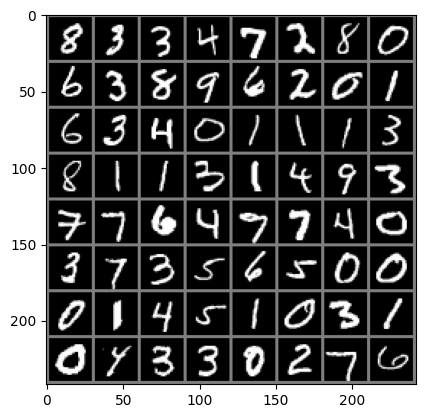

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of training data
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# Show images
imshow(torchvision.utils.make_grid(images))

In [25]:
images.shape

torch.Size([64, 1, 28, 28])

In [26]:
import torch.nn as nn
import torch.functional as F

# design a simple autoencoder model, where the encoder and decoder are both fully-connected layers
# the imput are 28*28=784, and the output are also 784
class Encoder:
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 12)
        self.fc4 = nn.Linear(12, 3)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x
    
class Decoder:
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(3, 12)
        self.fc2 = nn.Linear(12, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 784)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x
    
class Autoencoder:
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = Autoencoder()

In [27]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for images, _ in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.size(0), -1)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Calculate the loss
        loss = criterion(outputs, images)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")